## Machine Learning Model on General Mobility Insecurity

In this question, we have developed a transportation insecurity metric that is unrelated to the pure economic burden as we have explored in Question 1. In this question, we hope to use supervised learning models to understand the patterns and trends of general mobility insecurity. As for reference, here is a copy of how our general mobility insecurity metric was calculated again

Transportation insecurity can be divided into five major areas: availability, accessibility, accommodation, affordability, and acceptability. While in the first part we have gained an understanding on the economic stress of transportation, it is also important to understand the "soft" metrics of mobility insecurity, which includes availability, accessibility, and accommodation. Therefore, this section will start with setting up a new mobility insecurity metric, that takes into consideration both the connectivity of the living unit and overall commuting stress.\

The insecurity metric will be a total of 20. The higher, the more mobility insecurity that the household might face. Based on the exiting resource, here is how the insecurity metric will be calculated:\ Living situation:

1. -1 NHQSCHOOL = 2 (Disagree on having close proximity to schools)
2. -3 NHQPUBTRN = 2 (Disagree on having close proximity to public transportation)
3. -1 GARAGE !=’1’ (No garage)\
Mobility:

1. -1 COMDAYS>5 (Commute for more than 5 days a week)
2. -2 DRIVEALL>5 (Drive for more than 5 days of a week for commute)
3. -4 DIST >40 (40 miles is average daily commute distance for Americans)
4. -4 if BUS, SUBWAY, VAN = 1 AND NHQPUBTRN = 0 (Take public transportation while no reported good public transportation near residence)
5. -4 if SUBSIDY = 3 (no subsidy for public transportation) \
Source: Gould-Werth, Alix, Jamie Griffin, and Alexandra K. Murphy. "Developing a new measure of transportation insecurity: an exploratory factor analysis." Survey Practice 11, no. 2 (2018).

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.features import PCA as PCA_viz
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

from matplotlib import pyplot as plt

In [3]:
#df = pd.read_csv('occupied_features_cleaned.csv') Run this when accessing
df = pd.read_csv("C:/Users/Lydia/Documents/ML with Python/Group Project/occupied_features_cleaned.csv")
df.head()

,Unnamed: 0,YRBUILT,UNITSIZE,RMJOB,RMOWNHH,RMFAMILY,RMCHANGE,RMCOMMUTE,RMHOME,RMCOSTS,...,COMTYPE_Multimode,COMTYPE_Ptall,BUS_YES,SUBWAY_YES,VAN_Yes,SUBSIDY_None,SUBSIDY_NotReported,SUBSIDY_Partial,GARAGE_NoGarage,GARAGE_NotReported
0,1,1960,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,3,1970,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
2,4,1980,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,6,1980,3.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,...,0,0,0,0,0,0,1,0,1,0
4,7,1950,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
# Delete first col
df = df.drop(labels='Unnamed: 0', axis=1)

### Some visualizations and EDA to understand out insecurity metric better

<Axes: xlabel='INSECURITY', ylabel='Count'>

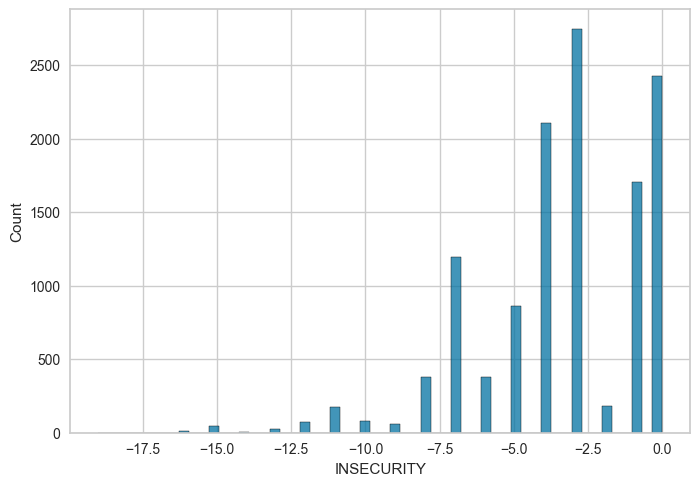

In [62]:
sns.histplot(data = df, x = 'INSECURITY')

<Axes: xlabel='INSECURITY', ylabel='load'>

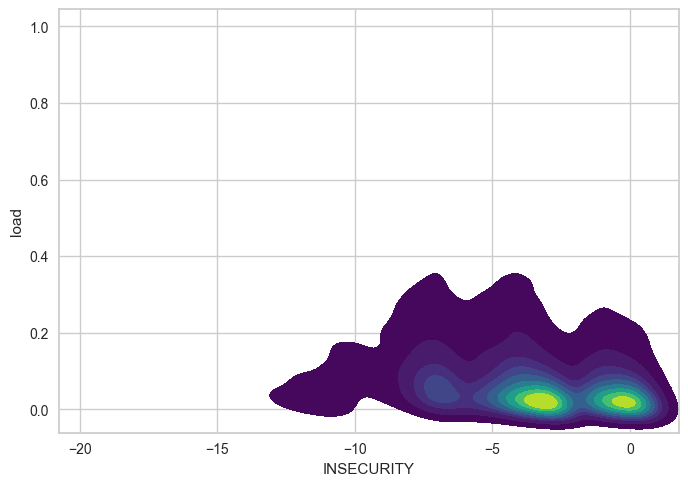

In [63]:
# Use a Kernal Density Estimation plot to understand potential correlation between commute cost and our insecurity metric
sns.kdeplot(data=df, x='INSECURITY', y='load', cmap='viridis', fill=True)

<Axes: xlabel='load', ylabel='INSECURITY'>

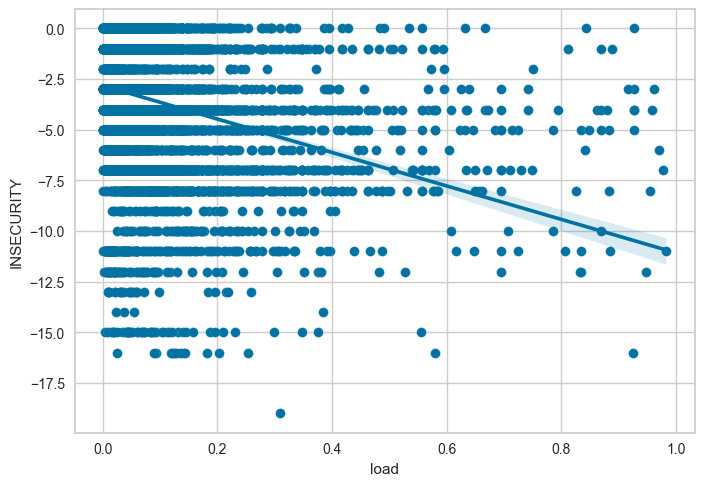

In [69]:
# Look at scatter plot and potential trend lines
sns.scatterplot(data=df, x='load',y='INSECURITY')
sns.regplot(x='load',y='INSECURITY', data=df)


From the above two visualizations, we can tell that there is a general positive correlation netween insecurity and transportation economic cost. Next let's look at the relationship between insecurity with some other features that are potentially related to transporation insecurity

<Axes: xlabel='RATINGNH', ylabel='INSECURITY'>

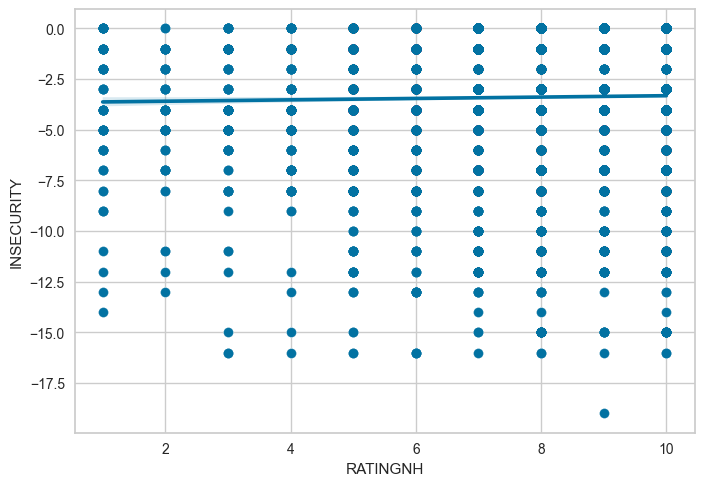

In [70]:
# Relationship between transportation insecurity and neighborhood rating
sns.scatterplot(data=df, x='RATINGNH',y='INSECURITY')
sns.regplot(x='RATINGNH',y='INSECURITY', data=df)

<Axes: xlabel='MARKETVAL', ylabel='INSECURITY'>

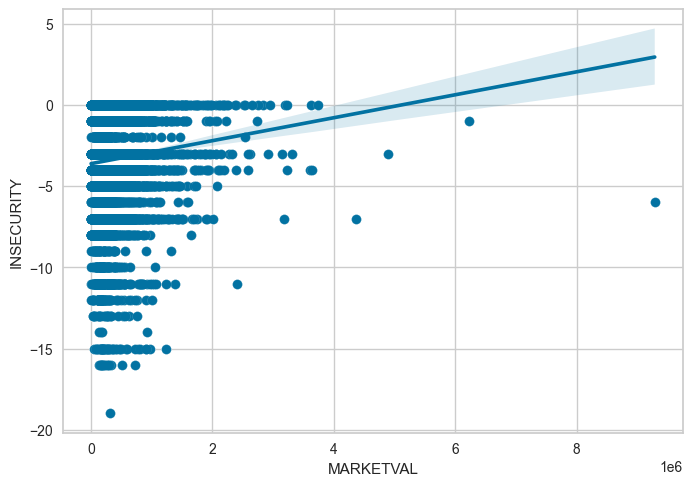

In [68]:
# Relationship between transportation insecurity and property market evaluation
sns.scatterplot(data=df, x='MARKETVAL', y='INSECURITY')
sns.regplot(x='MARKETVAL', y='INSECURITY', data=df)

<Axes: xlabel='INSECURITY', ylabel='NUMPEOPLE'>

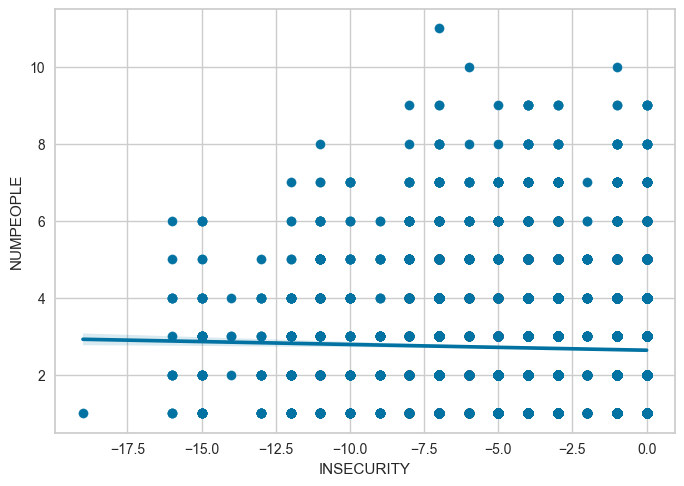

In [67]:
# Relationship between transportation insecurity and number of people in household
sns.scatterplot(data=df, x='INSECURITY', y='NUMPEOPLE')
sns.regplot(x="INSECURITY", y="NUMPEOPLE", data=df)

## Modeling

Features included in the calculation of insecurity
NHQSCHOOL
NHQPUBTRN
GARAGE
COMDAYS
DRIVEALL
DIST
BUS, SUBWAY, VAN 
SUBSIDY

In [8]:
df.columns

Index(['YRBUILT', 'UNITSIZE', 'RMJOB', 'RMOWNHH', 'RMFAMILY', 'RMCHANGE',
       'RMCOMMUTE', 'RMHOME', 'RMCOSTS', 'RMHOOD', 'RMOTHER', 'NUMPEOPLE',
       'MARKETVAL', 'RATINGNH', 'TOTHCAMT', 'COMDAYS', 'DRIVEALL', 'DIST',
       'INSECURITY', 'load', 'FOUNDTYPE_SINGLEFAM', 'FOUNDTYPE_Uncategorized',
       'BLD_LOWDEN', 'BLD_MIDDEN', 'BLD_MOBILE', 'BLD_SINGLEATTACHED',
       'BLD_SINGLEDETCH', 'BLD_Uncategorized', 'HEATFUEL_COALCOKE',
       'HEATFUEL_ELEC', 'HEATFUEL_FUELOIL', 'HEATFUEL_KEROSENE',
       'HEATFUEL_PIPEDGAS', 'HEATFUEL_SOLAR', 'HEATFUEL_Uncategorized',
       'HEATFUEL_WOOD', 'WATSOURCE_SYSTEM', 'WATSOURCE_Uncategorized',
       'ADEQUACY_MOD_INAD', 'ADEQUACY_SEV_INAD', 'MOVWHY_MOVE_FINANCE',
       'MOVWHY_Uncategorized', 'NRATE_BETTER_NH', 'NRATE_SAME_NH',
       'NRATE_Uncategorized', 'NRATE_WORSE_NH', 'HHGRAD_B_deg',
       'HHGRAD_Grad_deg', 'HHGRAD_HS', 'HHGRAD_noHS', 'MULTIGEN_NotMulti',
       'DISHH_2.0', 'house_load_month', 'RENTCNTRL_RNT_CONTROLLED',
    

In [5]:
# Obtain the X and y for the modeling
# Drop the columns that were used in the calculation of insecurity metric
drop_list_x = [
       'SUBSIDY_None', 'SUBSIDY_NotReported', 'SUBSIDY_Partial',
       'NHQSCHOOL_GoodSchool', 'NHQSCHOOL_NotReported', 'NHQPUBTRN_GoodTranp',
       'NHQPUBTRN_NotReported', 'GARAGE_NoGarage', 'GARAGE_NotReported',
       'BUS_YES', 'SUBWAY_YES', 'VAN_Yes', 'COMDAYS', 'DRIVEALL',
       'DIST', 'load', 'house_load_month', 'INSECURITY']
X = df.drop(drop_list_x, axis=1)
y = df['INSECURITY']
X.head()

,YRBUILT,UNITSIZE,RMJOB,RMOWNHH,RMFAMILY,RMCHANGE,RMCOMMUTE,RMHOME,RMCOSTS,RMHOOD,...,RENTCNTRL_RNT_CONTROLLED,RENTCNTRL_Uncategorized,HUDSUB_PUBLIC_H_SUBS,HUDSUB_Uncategorized,HUDSUB_VOUCHER,DBMISSMORT_NotReported,DBMISSMORT_ON_TIME,COMTYPE_Driveall,COMTYPE_Multimode,COMTYPE_Ptall
0,1960,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,1,0,0
1,1970,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,1,0,0,1,0
2,1980,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,1,0,0
3,1980,3.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,...,0,1,0,0,0,1,0,1,0,0
4,1950,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,1,0,0


In [6]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=19)

### Baseline Model

In this baseline model, we will use a linear regression model on the unprocessed data to see how the model could fit. 

In [7]:
def linear(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = model.score(X_train, y_train) 
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print('R2 Train: ', round(r2_train,3))
    print('R2 Test: ', round(r2_test,3))
    print('MSE TRAIN average: ', round(mse_train,3))
    print('MSE TEST average: ', round(mse_test,3))

    return model, r2_train, r2_test, mse_train, mse_test

model_base, r2_train_base, r2_test_base, mse_train_base, mse_test_base = linear(LinearRegression(), X_train, y_train, X_test, y_test)

R2 Train:  0.142
R2 Test:  0.104
MSE TRAIN average:  6.907
MSE TEST average:  7.075


### First Model: Linear Regression with Marginal Improvement

In [8]:
# Technique 1: Standardization
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
model_scaled, r2_train_scaled, r2_test_scaled, mse_train_scaled, mse_test_scaled = linear(LinearRegression(), X_train_scaled, 
                                                                                          y_train, X_test_scaled, y_test)

R2 Train:  0.142
R2 Test:  0.102
MSE TRAIN average:  6.907
MSE TEST average:  7.087


In [10]:
# Technique 2: Normalization
from sklearn.preprocessing import Normalizer, PolynomialFeatures

# Initialize the technique
normalizer = Normalizer()

# Apply the technique to both X_train and X_test
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.fit_transform(X_test)

In [11]:
model_norm, r2_train_norm, r2_test_norm, mse_train_norm, mse_test_norm = linear(LinearRegression(), X_train_norm, 
                                                                                          y_train, X_test_norm, y_test)

R2 Train:  0.024
R2 Test:  -0.471
MSE TRAIN average:  7.856
MSE TEST average:  11.611


#### Linear Model + Sequential Selector

In [12]:
# Initialize SequentialFeatureSelector with LinearRegression as the estimator.
sfs = SequentialFeatureSelector(estimator=LinearRegression(),
                                n_features_to_select='auto',
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error',
                                cv = 10)

# Fit the data to the SFS. 
sfs = sfs.fit(X_train_scaled, y_train)

# Get selected features
feature_names = np.array(X.columns)
selected_feature_names = feature_names[sfs.get_support()].tolist()
print("Selected features:", selected_feature_names)

# Transform your X_train and X_test to include only the selected features. Hint: use .transform()
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)

# Display the shape of transformed X_train_selected and X_test_selected for verification
print("Transformed X_train shape:",X_train_sfs.shape)
print("Transformed X_test shape:",X_test_sfs.shape)

Selected features: ['YRBUILT', 'UNITSIZE', 'RMOWNHH', 'RMHOME', 'RMHOOD', 'MARKETVAL', 'RATINGNH', 'FOUNDTYPE_Uncategorized', 'BLD_LOWDEN', 'BLD_MOBILE', 'BLD_SINGLEATTACHED', 'HEATFUEL_ELEC', 'HEATFUEL_PIPEDGAS', 'WATSOURCE_SYSTEM', 'ADEQUACY_MOD_INAD', 'MOVWHY_Uncategorized', 'NRATE_BETTER_NH', 'HHGRAD_B_deg', 'HHGRAD_Grad_deg', 'MULTIGEN_NotMulti', 'DISHH_2.0', 'RENTCNTRL_Uncategorized', 'HUDSUB_PUBLIC_H_SUBS', 'HUDSUB_Uncategorized', 'DBMISSMORT_ON_TIME', 'COMTYPE_Driveall', 'COMTYPE_Multimode', 'COMTYPE_Ptall']
Transformed X_train shape: (9960, 28)
Transformed X_test shape: (2490, 28)


In [13]:
model_sfs, r2_train_sfs, r2_test_sfs, mse_train_sfs, mse_test_sfs = linear(LinearRegression(), X_train_sfs, 
                                                                                          y_train, X_test_sfs, y_test)

coef_dict = {}
for coef, feat in zip(model_sfs.coef_,X_train.columns.to_list()):
    coef_dict[feat] = coef

coef_lr = pd.DataFrame.from_dict(coef_dict, orient = 'index', columns = ['LM_Coefficient'])
print(coef_lr)

R2 Train:  0.14
R2 Test:  0.099
MSE TRAIN average:  6.926
MSE TEST average:  7.11
                         LM_Coefficient
YRBUILT                       -0.279300
UNITSIZE                      -0.222055
RMJOB                          0.132366
RMOWNHH                       -0.308908
RMFAMILY                       0.141600
RMCHANGE                       0.245756
RMCOMMUTE                      0.139537
RMHOME                         0.345273
RMCOSTS                       -0.120583
RMHOOD                        -0.133956
RMOTHER                        0.060302
NUMPEOPLE                      0.110083
MARKETVAL                      0.291107
RATINGNH                       0.297303
TOTHCAMT                      -0.058254
FOUNDTYPE_SINGLEFAM            0.067176
FOUNDTYPE_Uncategorized       -0.038954
BLD_LOWDEN                     0.048852
BLD_MIDDEN                     0.111056
BLD_MOBILE                    -0.066267
BLD_SINGLEATTACHED            -0.027447
BLD_SINGLEDETCH               -0.10597

#### Polynomial Regression

In [14]:
# your code here
degrees = [1,2]

def train_and_evaluate_poly(X_train, X_test, y_train, y_test, deg):
    ## Initialize the object
    polynomial_features = PolynomialFeatures(degree = deg, include_bias = False)

    ## Pass X_train and X_test to get a tranformed version
    X_train_polynomial = polynomial_features.fit_transform(X_train)
    X_test_polynomial = polynomial_features.fit_transform(X_test)

    model_polynomial_regression = LinearRegression()
    model_polynomial_regression.fit(X_train_polynomial, y_train)

    y_pred_train = model_polynomial_regression.predict(X_train_polynomial)
    y_pred_test = model_polynomial_regression.predict(X_test_polynomial)

    ## Evaluation metric 1: r2 values
    r2_train = model_polynomial_regression.score(X_train_polynomial, y_train)
    r2_test = model_polynomial_regression.score(X_test_polynomial, y_test)

    ## Evaluation metric 2: Mean squared error (MSE)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return r2_train, r2_test, mse_train, mse_test

def print_results(results, label):
    print(f"Results for Degree {label}:")
    print(f"  R-squared (Train): {results[0]:.4f}")
    print(f"  R-squared (Test) : {results[1]:.4f}")
    print(f"  MSE (Train)      : {results[2]:.4f}")
    print(f"  MSE (Test)       : {results[3]:.4f}")
    print()

model_results = []
for deg in degrees:
    model_results.append(train_and_evaluate_poly(X_train, X_test, y_train, y_test, deg))
    print_results(model_results[deg-1], deg)

Results for Degree 1:
  R-squared (Train): 0.1423
  R-squared (Test) : 0.1038
  MSE (Train)      : 6.9075
  MSE (Test)       : 7.0748

Results for Degree 2:
  R-squared (Train): 0.2633
  R-squared (Test) : -3.3921
  MSE (Train)      : 5.9326
  MSE (Test)       : 34.6728



#### Lasso Regression

In [15]:
# Lasso Regression 
# Getting 300 values on a logarithmic scale
alphas = np.logspace(-5, 5, 300)

# Iterating through the alphas
lasso_model_coefficients = []
mse_lassos = []
avg_mse_lassos = []

model_lasso = Lasso(max_iter = 100000, tol = 0.1) 

for a in alphas:
    model_lasso.set_params(alpha = a)
    model_lasso.fit(X_train_scaled, y_train)
    mse_lasso = cross_val_score(model_lasso, X_train_scaled, 
                                      y_train, scoring = 'neg_mean_squared_error', cv = 10) 
    
    lasso_model_coefficients.append(model_lasso.coef_)
    mse_lassos.append(mse_lasso)
    avg_mse_lassos.append(np.mean(-mse_lasso))

# Find the lowest value of MSE test value
min_mse_lasso = np.min(avg_mse_lassos)
print("Min MSE Test: ", min_mse_lasso)

# Find the index of the lowest MSE test value (use np.argmin)
min_mse_lasso_index = np.argmin(avg_mse_lassos)
print("Index of Min MSE test: ", min_mse_lasso_index)

# Call alphas with the index of the lowest MSE test value
best_alpha_lasso = alphas[min_mse_lasso_index]
print("Best alpha: ", best_alpha_lasso)

Min MSE Test:  6.985809561862626
Index of Min MSE test:  71
Best alpha:  0.002369092074182632


In [16]:
model_lasso_best = Lasso(alpha = best_alpha_lasso, max_iter = 100000, tol = 0.1)

model_lasso, r2_train_lasso, r2_test_lasso, mse_train_lasso, mse_test_lasso = linear(model_lasso_best, X_train_scaled, 
                                                                                          y_train, X_test_scaled, y_test)

# Extracting the values of coefficients at the best alpha and adding to df
coef_dict_lasso = {}
for coef, feat in zip(model_lasso.coef_,X_train.columns.to_list()):
    coef_dict_lasso[feat] = coef

coef_lasso = pd.DataFrame.from_dict(coef_dict_lasso, orient = 'index', columns = ['LM_Coefficient'])
print(coef_lasso)

R2 Train:  0.142
R2 Test:  0.102
MSE TRAIN average:  6.91
MSE TEST average:  7.088
                          LM_Coefficient
YRBUILT                        -0.269813
UNITSIZE                       -0.213197
RMJOB                          -0.001567
RMOWNHH                         0.105818
RMFAMILY                        0.105386
RMCHANGE                        0.094187
RMCOMMUTE                      -0.199111
RMHOME                         -0.299692
RMCOSTS                         0.037175
RMHOOD                          0.162013
RMOTHER                        -0.000000
NUMPEOPLE                      -0.039613
MARKETVAL                       0.242095
RATINGNH                        0.132133
TOTHCAMT                        0.012962
FOUNDTYPE_SINGLEFAM             0.047990
FOUNDTYPE_Uncategorized         0.314443
BLD_LOWDEN                     -0.111709
BLD_MIDDEN                     -0.003449
BLD_MOBILE                     -0.137700
BLD_SINGLEATTACHED              0.020063
BLD_SINGLEDETCH

### Non-linear Models

In [17]:
# Copied and Pasted codes from question 1 on model building and evaluation
def erm(model_type, X_train, y_train, X_test, y_test, seed):

    # Step 1: Initialize a model object
    if model_type == 'DecisionTreeRegressor':
      model = DecisionTreeRegressor(random_state = seed) 
    elif model_type == 'RandomForestRegressor':
      model = RandomForestRegressor(random_state = seed)
    elif model_type == 'GradientBoostingRegressor':
      model = GradientBoostingRegressor(random_state = seed)
    else:
      print('Please specify the model type')

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3-4: Evaluate the model performance

    ## Average cross-validated r-squared (hint: call cross_val_score with scoring='r2')
    r_squared_train_cross_val = cross_val_score(model, X_train, y_train, scoring = 'r2').mean()
    r_sq_test = cross_val_score(model, X_test, y_test, scoring = 'r2').mean()
    
    print('R-squared (Train):', round(r_squared_train_cross_val, 3))
    print('R-squared (Test):', round(r_sq_test, 3))

    return model, r_squared_train_cross_val, r_sq_test

def tuning(model_type, X_train, y_train, parameters_list, cv = 5):
    if model_type == 'DecisionTreeRegressor':
      model = DecisionTreeRegressor(random_state = seed) 
    elif model_type == 'RandomForestRegressor':
      model = RandomForestRegressor(random_state = seed)
    elif model_type == 'GradientBoostingRegressor':
      model = GradientBoostingRegressor(random_state = seed)
    else:
      print('Please specify the model type')

    grid_search_model = GridSearchCV(model, parameters_list, scoring = 'neg_mean_squared_error', cv=cv)
    grid_search_model.fit(X_train, y_train)
    print("Best Parameters:", grid_search_model.best_params_)
    model_finetuned = grid_search_model.best_estimator_

    return model_finetuned


def erm_best(model, X_train, y_train, X_test, y_test):

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3: Get performance metrics
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = model.score(X_train, y_train) 
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print('Final Results from Tuning:  ')
    print('R2 Train: ', round(r2_train,3))
    print('R2 Test: ', round(r2_test,3))
    print('MSE Train: ', round(mse_train,3))
    print('MSE Test: ', round(mse_test,3))

    return model, r2_train, r2_test, mse_train, mse_test


#### Decision Tree

In [18]:
seed=6

In [19]:
model_dtr  = erm('DecisionTreeRegressor', X_train_scaled, y_train, X_test_scaled, y_test, seed)

R-squared (Train): -0.782
R-squared (Test): -0.832


In [29]:
# Hyperparameter tuning
parameters_list = {
    'max_depth': [None, 5, 10, 15, 20],
    'criterion': ['squared_error', 'absolute_error']
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 5}


In [32]:
model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Final Results from Tuning:  
R2 Train:  0.154
R2 Test:  0.086
MSE Train:  6.814
MSE Test:  7.213


In [35]:
parameters_list = {
    'max_depth': [5],
    'criterion': ['squared_error'], 
    'min_samples_split': [20, 30, 40]
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 40}


In [36]:
model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Final Results from Tuning:  
R2 Train:  0.153
R2 Test:  0.086
MSE Train:  6.821
MSE Test:  7.217


In [20]:
parameters_list = {
    'max_depth': [5],
    'criterion': ['squared_error'], 
    'min_samples_split': [40], 
    'min_samples_leaf': [10, 20, 30]
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 40}


In [21]:
model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Final Results from Tuning:  
R2 Train:  0.149
R2 Test:  0.079
MSE Train:  6.853
MSE Test:  7.271


#### Random Forest

In [22]:
model_rfr = erm('RandomForestRegressor', X_train_scaled, y_train, X_test_scaled, y_test, seed)

R-squared (Train): 0.111
R-squared (Test): 0.048


In [39]:
parameters_list = {
    'criterion': ['squared_error', 'absolute_error'],  # Function to measure the quality of a split
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'squared_error'}
Final Results from Tuning:  
R2 Train:  0.873
R2 Test:  0.059
MSE Train:  1.022
MSE Test:  7.43


In [40]:
parameters_list = {
    'criterion': ['squared_error'],  # Function to measure the quality of a split
    'max_depth': [5, 10, 15]  # Maximum depth of the trees
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 10}
Final Results from Tuning:  
R2 Train:  0.395
R2 Test:  0.094
MSE Train:  4.87
MSE Test:  7.15


In [27]:
parameters_list = {
    'criterion': ['squared_error'],  # Function to measure the quality of a split
    'max_depth': [10],  # Maximum depth of the trees
    'min_samples_split': [50, 60, 70]  # I have tuned from 10 to 70 here 
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 50}
Final Results from Tuning:  
R2 Train:  0.273
R2 Test:  0.105
MSE Train:  5.859
MSE Test:  7.063


#### Gradient Boosting

In [23]:
model_gbr  = erm('GradientBoostingRegressor', X_train_scaled, y_train,
                                                                    X_test_scaled, y_test, seed)

R-squared (Train): 0.145
R-squared (Test): 0.08


In [47]:
parameters_list = {
    'learning_rate': [0.01, 0.1, 0.2]  # Learning rate shrinks the contribution of each tree
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.1}
Final Results from Tuning:  
R2 Train:  0.201
R2 Test:  0.097
MSE Train:  6.431
MSE Test:  7.132


In [49]:
parameters_list = {
    'learning_rate': [0.1],  # Learning rate shrinks the contribution of each tree
    'max_depth': [1, 2, 3] # Have tested 1-7
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Final Results from Tuning:  
R2 Train:  0.201
R2 Test:  0.097
MSE Train:  6.431
MSE Test:  7.132


In [53]:
parameters_list = {
    'learning_rate': [0.1],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3],
    'min_samples_split': [10, 15, 20] # Have tested 1-50
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10}
Final Results from Tuning:  
R2 Train:  0.202
R2 Test:  0.098
MSE Train:  6.425
MSE Test:  7.118


In [24]:
parameters_list = {
    'learning_rate': [0.1],  
    'max_depth': [3],
    'min_samples_split': [10],
    'min_samples_leaf': [4, 6, 8]
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Final Results from Tuning:  
R2 Train:  0.202
R2 Test:  0.096
MSE Train:  6.429
MSE Test:  7.134


In [28]:
#Create a dictionary to hold evauluation metrics from both models
data = {

    'Model': [
        'Base',
        'Linear + Standardization',
        'Linear + Norm',
        'Linear + Feature Selection',
        'Lasso',
        'Decision Tree', 
        'Random Forest', 
        'Gradient Boosting'], 

    'R2 Train': [
        r2_train_base,
        r2_train_scaled, 
        r2_train_norm,
        r2_train_sfs,  
        r2_train_lasso,
        r2_train_dtr, 
        r2_train_rfr,
        r2_train_gbr],

    'R2 Test': [
        r2_test_base,
        r2_test_scaled, 
        r2_test_norm,
        r2_test_sfs,  
        r2_test_lasso,
        r2_test_dtr, 
        r2_test_rfr,
        r2_test_gbr],
   
    'MSE Train': [
        mse_train_base,
        mse_train_scaled, 
        mse_train_norm,
        mse_train_sfs,  
        mse_train_lasso,
        mse_train_dtr, 
        mse_train_rfr,
        mse_train_gbr],
    
    'MSE Test': [
        mse_test_base,
        mse_test_scaled, 
        mse_test_norm,
        mse_test_sfs,  
        mse_test_lasso,
        mse_test_dtr, 
        mse_test_rfr,
        mse_test_gbr]

    }

# Create and display a dataframe
df = pd.DataFrame(data)
df


,Model,R2 Train,R2 Test,MSE Train,MSE Test
0,Base,0.142277,0.103806,6.907489,7.074847
1,Linear + Standardization,0.142277,0.102237,6.907489,7.087228
2,Linear + Norm,0.024462,-0.470853,7.856288,11.611387
3,Linear + Feature Selection,0.140026,0.099396,6.925619,7.109654
4,Lasso,0.141994,0.102100,6.909772,7.088307
5,Decision Tree,0.149028,0.078985,6.853123,7.270787
6,Random Forest,0.272516,0.105304,5.858638,7.063015
7,Gradient Boosting,0.201698,0.096324,6.428954,7.133908


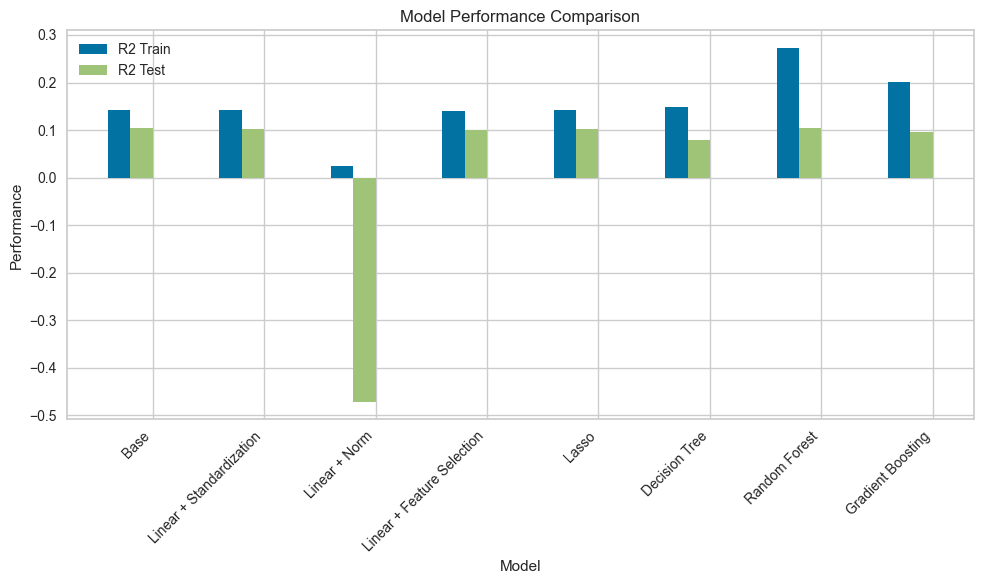

In [29]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Get the number of observations
num_obs = len(df)

# Define the width of each bar
bar_width = 0.2

# Set the positions for the bars
index = range(num_obs)

# Plotting R2 Train
ax.bar(index, df['R2 Train'], bar_width, label='R2 Train', color='b')

# Plotting R2 Test
ax.bar([i + bar_width for i in index], df['R2 Test'], bar_width, label='R2 Test', color='g')

# Set the x-axis ticks and labels
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df['Model'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Performance')
ax.set_title('Model Performance Comparison')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

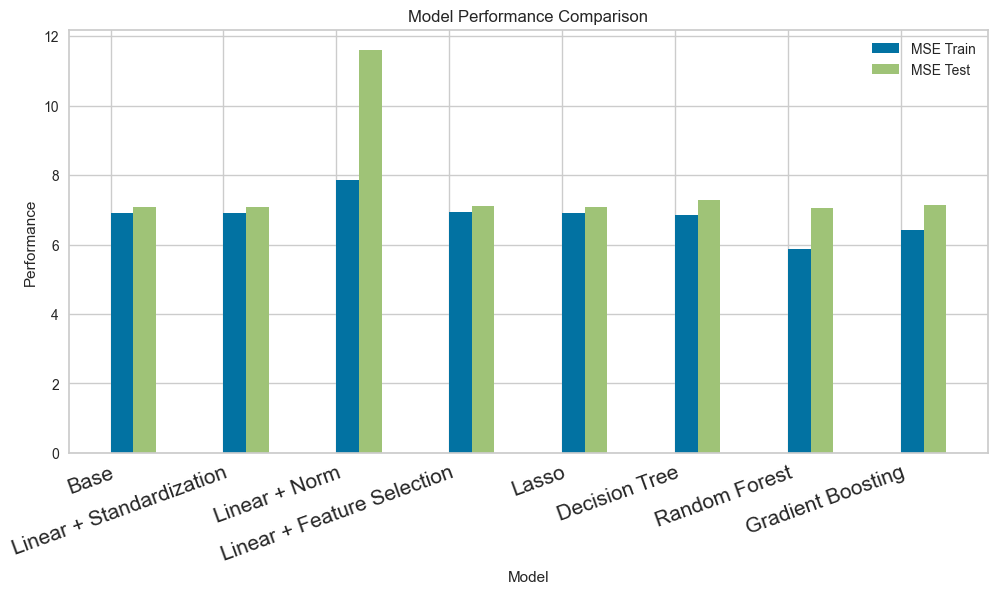

In [30]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Get the number of observations
num_obs = len(df)

# Define the width of each bar
bar_width = 0.2

# Set the positions for the bars
index = range(num_obs)

# Plotting MSE Train
ax.bar([i + 2 * bar_width for i in index], df['MSE Train'], bar_width, label='MSE Train', color='b')

# Plotting MSE Test
ax.bar([i + 3 * bar_width for i in index], df['MSE Test'], bar_width, label='MSE Test', color='g')

# Set the x-axis ticks and labels
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df['Model'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=20, ha='right')
ax.set_xticklabels(df['Model'], fontsize=15, wrap = True)  # Adjust font size as needed


# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Performance')
ax.set_title('Model Performance Comparison')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

Overall, all the models fail to produce a descent model to predict the non-economic transportation insecurity. It partially also expected given the lack of trends we observed in the EDA part of this project. Potential reason for this is that in the making of the insecurity metrics, all the potentially transit-related metric has been used and therefore excluded from the model building. As a result, the training features mostly include a lot of completely unrelated features to transportation. 

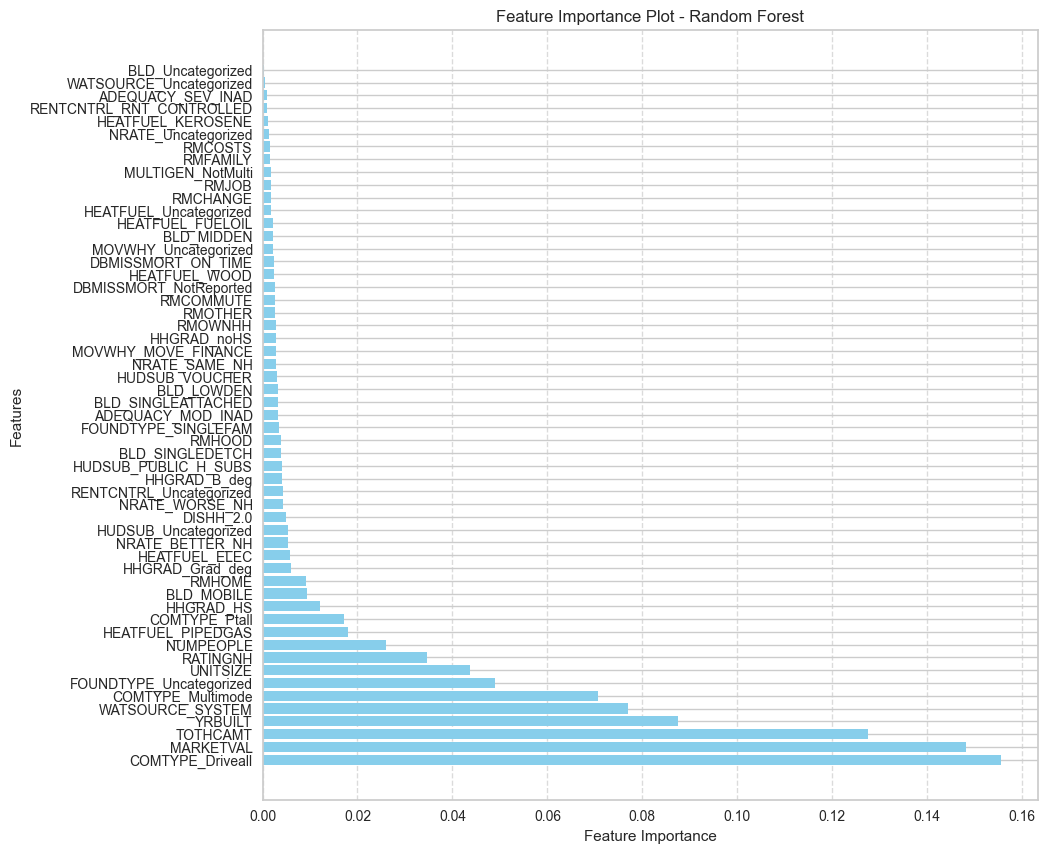

In [36]:
feature_importances = model_rfr_best.feature_importances_

# Get feature names
feature_names = X_train.columns

data = {
    'Feature Name': feature_names,
    'Importance': feature_importances
     }

df_rfr_features = pd.DataFrame(data)
df_rfr_features_nonzero = df_rfr_features[df_rfr_features['Importance'] != 0].copy()
df_rfr_features_nonzero.sort_values(by = 'Importance', ascending = False, inplace= True)

plt.figure(figsize=(10, 10))
plt.barh(df_rfr_features_nonzero['Feature Name'], df_rfr_features_nonzero['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot - Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()